# Importing Libraries

In [15]:
import numpy as np
import os
import tensorflow as tf
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from absl import logging
import shutil

from tflite_model_maker import object_detector
from tflite_model_maker.object_detector import DataLoader
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec

# Setting Up for TensorFlow 2.0

In [16]:
assert tf.__version__.startswith('2')

# Suppress TensorFlow and absl logs for cleaner output
tf.get_logger().setLevel('ERROR')
logging.set_verbosity(logging.ERROR)

# Dataset Preprocessing and Augmentation

### Directory paths

In [17]:
base_dir = r'Object-detection-dataset'
train_dir = 'Object-detection-dataset/train'
valid_dir = 'Object-detection-dataset/valid'

### Extracting Label Map

In [18]:
# Extract labels from XML files
def extract_labels(directory):
    labels = set()
    for filename in os.listdir(directory):
        if filename.endswith(".xml"):
            tree = ET.parse(os.path.join(directory, filename))
            root = tree.getroot()
            for obj in root.findall('object'):
                labels.add(obj.find('name').text)
    return labels

# Extract and merge all labels
train_labels = extract_labels(train_dir)
valid_labels = extract_labels(valid_dir)
all_labels = sorted(train_labels.union(valid_labels))

# Convert to the required label_map
label_map = {i + 1: name for i, name in enumerate(all_labels)}

# Display the labels
print("Labels used in your annotations:")
for label in all_labels:
    print(label)

Labels used in your annotations:
Tom Tom
aeroplane
apple
backpack
banana
baseball bat
baseball glove
bear
bed
bench
bicycle
bin
bird
boat
book
bottle
bowl
broccoli
bus
cake
car
cat
cell phone
chair
clock
cng
cow
cup
diningtable
dog
donut
door
elephant
fire hydrant
fork
frisbee
giraffe
glass partition
handbag
horse
hot dog
keyboard
kite
knife
laptop
microwave
motorbike
motorcycle
mouse
orange
oven
parking meter
person
pillar
pizza
pottedplant
railing
refrigerator
remote
rickshaw
sandwich
scissors
sheep
shelf
sink
skateboard
skis
snowboard
sofa
spoon
sports ball
stair
stop sign
suitcase
surfboard
table
teddy bear
tempu
tennis racket
tie
toilet
traffic light
train
tree
truck
tvmonitor
umbrella
van
vase
wine glass
zebra


### Data Augmentation

In [19]:
def augment_image(image, bbox):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, 0.9, 1.1)
    return image, bbox

### Apply and Save Augmented Images

In [20]:
aug_dir = os.path.join(base_dir, 'train_augmented')
os.makedirs(aug_dir, exist_ok=True)

for file in os.listdir(train_dir):
    if file.endswith('.jpg') or file.endswith('.png'):
        base_name = os.path.splitext(file)[0]
        img_path = os.path.join(train_dir, file)
        xml_path = os.path.join(train_dir, base_name + '.xml')

        if not os.path.exists(xml_path):
            continue  # Skip if annotation missing

        # Load and augment image
        image = tf.io.read_file(img_path)
        image = tf.image.decode_jpeg(image, channels = 3)
        image = tf.image.resize(image, (256, 256))
        image = tf.cast(image, tf.uint8)

        aug_image, _ = augment_image(image, None)
        aug_image = tf.image.encode_jpeg(tf.cast(aug_image, tf.uint8))

        # Save augmented image
        aug_img_name = base_name + '_aug.jpg'
        aug_img_path = os.path.join(aug_dir, aug_img_name)
        tf.io.write_file(aug_img_path, aug_image)

        # Copy original XML with new name
        aug_xml_name = base_name + '_aug.xml'
        shutil.copy(xml_path, os.path.join(aug_dir, aug_xml_name))

### Merge Original and Augmented Training Data

In [21]:
train_combined_dir = os.path.join(base_dir, 'train_combined')
os.makedirs(train_combined_dir, exist_ok = True)

for src_dir in [train_dir, aug_dir]:
    for f in os.listdir(src_dir):
        shutil.copy(os.path.join(src_dir, f), os.path.join(train_combined_dir, f))

### Load Dataset with Augmented Data

In [22]:
train_data = object_detector.DataLoader.from_pascal_voc(
    train_combined_dir,
    train_combined_dir,
    label_map
)

val_data = object_detector.DataLoader.from_pascal_voc(
    valid_dir,
    valid_dir,
    label_map
)

# Initialize EfficientDet-Lite1 Pretrained Model

In [23]:
spec = model_spec.get("efficientdet_lite1")

initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True
)

spec.optimizer = Adam(learning_rate=lr_schedule)

# Model Training

### Training Configuration

In [24]:
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 8
EPOCH_SIZE = 50

### Training

In [25]:
model = object_detector.create(
    train_data,
    model_spec=spec,
    batch_size=BATCH_SIZE,
    train_whole_model=False,  # Freeze backbone, train only detection head
    validation_data=val_data,
    epochs=EPOCH_SIZE,
    do_train=True,
)

Epoch 1/50
102/102 [==============================] - 489s 4s/step - det_loss: 1.8861 - cls_loss: 1.3135 - box_loss: 0.0115 - reg_l2_loss: 0.0206 - loss: 1.9067 - learning_rate: 0.0090 - gradient_norm: 0.6437 - val_det_loss: 1.5533 - val_cls_loss: 1.1602 - val_box_loss: 0.0079 - val_reg_l2_loss: 0.0206 - val_loss: 1.5739
Epoch 2/50
102/102 [==============================] - 430s 4s/step - det_loss: 1.5104 - cls_loss: 1.1109 - box_loss: 0.0080 - reg_l2_loss: 0.0206 - loss: 1.5310 - learning_rate: 0.0100 - gradient_norm: 0.8103 - val_det_loss: 1.4144 - val_cls_loss: 1.0664 - val_box_loss: 0.0070 - val_reg_l2_loss: 0.0206 - val_loss: 1.4350
Epoch 3/50
102/102 [==============================] - 431s 4s/step - det_loss: 1.4094 - cls_loss: 1.0537 - box_loss: 0.0071 - reg_l2_loss: 0.0206 - loss: 1.4300 - learning_rate: 0.0099 - gradient_norm: 0.8813 - val_det_loss: 1.3378 - val_cls_loss: 1.0110 - val_box_loss: 0.0065 - val_reg_l2_loss: 0.0206 - val_loss: 1.3585
Epoch 4/50
102/102 [===========

# Model Summary and Plot

Model: ""
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  multiple                  4234512   
                                                                 
 class_net/class-predict (Se  multiple                 73683     
 parableConv2D)                                                  
                                                                 
 box_net/box-predict (Separa  multiple                 3996      
 bleConv2D)                                                      
                                                                 
Total params: 4,312,191
Trainable params: 4,249,119
Non-trainable params: 63,072
_________________________________________________________________


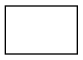

In [30]:
model.model.summary()
plot_model(model.model, show_shapes=True, show_layer_names=True, dpi=96)

# Learning Curve

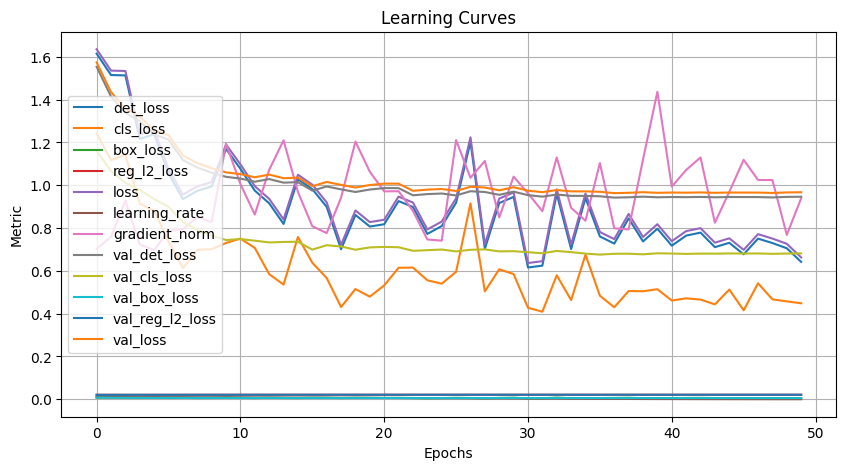

In [27]:
history = model.model.history

if history and hasattr(history, 'history'):
    plt.figure(figsize = (10, 5))
    for key, values in history.history.items():
        plt.plot(values, label=key)
    plt.title('Learning Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    plt.legend()
    plt.grid(True)
    plt.show()

### Model Evaluation

In [28]:
metrics = model.evaluate(val_data)

print("\nEvaluation Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

2/2 [==============================] - 188s 63s/step


Evaluation Metrics:
AP: 0.1736
AP50: 0.2772
AP75: 0.1890
APs: 0.0085
APm: 0.1857
APl: 0.2988
ARmax1: 0.1551
ARmax10: 0.2386
ARmax100: 0.2423
ARs: 0.0228
ARm: 0.2739
ARl: 0.3934
AP_/Tom Tom: -1.0000
AP_/aeroplane: 0.4295
AP_/apple: -1.0000
AP_/backpack: 0.0304
AP_/banana: -1.0000
AP_/baseball bat: 0.1020
AP_/baseball glove: 0.0000
AP_/bear: -1.0000
AP_/bed: -1.0000
AP_/bench: 0.1219
AP_/bicycle: 0.0886
AP_/bin: 0.0000
AP_/bird: 0.0000
AP_/boat: 0.0000
AP_/book: 0.0258
AP_/bottle: 0.2906
AP_/bowl: 0.0000
AP_/broccoli: -1.0000
AP_/bus: 0.3848
AP_/cake: 0.0000
AP_/car: 0.2263
AP_/cat: 0.0337
AP_/cell phone: 0.0000
AP_/chair: 0.0724
AP_/clock: 0.2059
AP_/cng: 0.1520
AP_/cow: 0.3724
AP_/cup: 0.1626
AP_/diningtable: 0.1390
AP_/dog: 0.1640
AP_/donut: -1.0000
AP_/door: -1.0000
AP_/elephant: 0.7809
AP_/fire hydrant: 0.6624
AP_/fork: 0.0000
AP_/frisbee: 0.7052
AP_/giraffe: -1.0000
AP_/glass partition: -1.0000
AP_/handbag: 0.0101
AP_/horse: 0.

# Export TFLite (float16)

In [29]:
from tflite_model_maker.config import QuantizationConfig

model.export(
    export_dir='.',
    export_format=[ExportFormat.TFLITE],
    quantization_config=QuantizationConfig.for_float16()
)

os.rename("model.tflite", "EfficientDet_Lite1_detector_float16.tflite")